In [2]:
# https://towardsdatascience.com/drowsiness-detection-using-convolutional-neural-networks-face-recognition-and-tensorflow-56cdfc8315ad
%pip install sklearn
%pip install -U -q segmentation-models
%pip install tensorflow==2.1.0
%pip install -q keras==2.3.1
%pip install -q tensorflow-estimator==2.1.

## Imports libs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

import segmentation_models as sm
import cv2
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from keras.models import Sequential
#from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout

#import keras

from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import layers


def loadImages(folder, eyes = 0):
    count = 0
    error_count = 0
    images = []
    for filename in os.listdir(folder):
        try:
            image = cv2.imread(os.path.join(folder, filename))
            image = cv2.resize(image, (299,299)) 

            images.append([image, eyes])
        except:
            error_count += 1
            print('Error count = ' + str(error_count))
            continue
        
        count += 1
        if count % 500 == 0:
            print('Import Image Successful Count = ' + str(count))

    return images

folder="data/train/open"
open_eyes = loadImages(folder, 0)

folder="data/train/close" 
closed_eyes = loadImages(folder, 1)   
eyes = closed_eyes + open_eyes

X = [] 
y = [] 
for features, label in eyes: 
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, 299, 299, 3)

y = np.array(y)

X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

model = tf.keras.applications.inception_v3.InceptionV3()


model.summary()

for layer in model.layers:
    layer.trainable = False

base_input = model.layers[0].input 

base_output = model.layers[-2].output

Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer) ## one node (1 or 0) == Open or closed
fina_output = layers.Activation('sigmoid')(final_output) # Binary classification thus using sigmoid

model = keras.Model(inputs = base_input, outputs = final_output)

model.summary()

model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['acc'])

# Create an Instance of Early Stopping Callback
#early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)


# fitting the model
history = model.fit(X_train,
            y_train,
            batch_size=800,
            validation_data=(X_test, y_test),
            epochs=40)

#history = new_model.fit(x = features_train, y = labels_train, epochs = 40, batch_size = 4, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

# evaluate the model 
model.evaluate(X_test, y_test, verbose=1)

model.save('cnn_model_transfer_learning_InceptionV3.h5')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Import Image Successful Count = 500
Import Image Successful Count = 1000
Import Image Successful Count = 500
Import Image Successful Count = 1000
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
_______

Train on 1817 samples, validate on 606 samples
Epoch 1/40
1817/1817 [==============================] - 187s 103ms/sample - loss: 2.6620 - acc: 0.5173 - val_loss: 3.4210 - val_acc: 0.5198
Epoch 2/40
1817/1817 [==============================] - 143s 79ms/sample - loss: 1.8894 - acc: 0.5487 - val_loss: 6.5197 - val_acc: 0.5066
Epoch 3/40
1817/1817 [==============================] - 144s 79ms/sample - loss: 1.7856 - acc: 0.5520 - val_loss: 5.1545 - val_acc: 0.5165
Epoch 4/40
1817/1817 [==============================] - 152s 83ms/sample - loss: 1.4009 - acc: 0.5861 - val_loss: 2.8016 - val_acc: 0.5215
Epoch 5/40
1817/1817 [==============================] - 163s 90ms/sample - loss: 1.6256 - acc: 0.5916 - val_loss: 5.8947 - val_acc: 0.5066
Epoch 6/40
1817/1817 [==============================] - 158s 87ms/sample - loss: 1.7203 - acc: 0.5812 - val_loss: 6.2198 - val_acc: 0.5083
Epoch 7/40
1817/1817 [==============================] - 149s 82ms/sample - loss: 1.4607 - acc: 0.6153 - val_loss: 2.57

In [10]:
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix 


predictions = model.predict(X_test)  

In [11]:
#print(predictions)

In [12]:
predictions = np.where(predictions > 0.5, 1, 0)
#print(predictions)


In [13]:
# Confusion Matrix
print("Accuracy", metrics.accuracy_score(y_test, predictions))
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  

Accuracy 0.6122112211221122
[[189 119]
 [116 182]]
              precision    recall  f1-score   support

           0       0.62      0.61      0.62       308
           1       0.60      0.61      0.61       298

    accuracy                           0.61       606
   macro avg       0.61      0.61      0.61       606
weighted avg       0.61      0.61      0.61       606



In [14]:
# evaluate the model 
model.evaluate(X_test, y_test, verbose=1)

606/606 [==============================] - 18s 29ms/sample - loss: 0.9871 - acc: 0.6122


[0.9871469584628694, 0.6122112]

In [15]:
# Model Summary
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [16]:
#conda install pydot pydotplus
#from keras.utils import plot_model
%pip install pydot 
%pip install pydotplus
%pip install graphviz
from tensorflow.keras.utils import plot_model

#from keras.utils.vis_utils import plot_model
import IPython
import keras

plot_model(model, to_file='model.png',show_shapes=True)
IPython.display.Image("model.png")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


InvocationException: GraphViz's executables not found

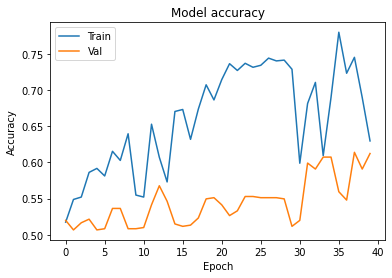

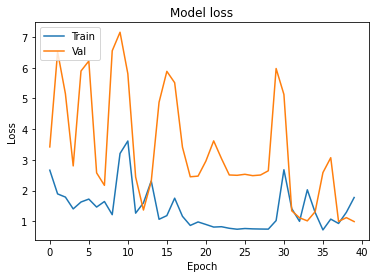

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [18]:
for layer in model.layers:
    weights = layer.get_weights()
    print(weights)

[]
[array([[[[-4.59105551e-01, -4.14526574e-02, -3.62577499e-03,
          -9.87672508e-02, -3.37070860e-02,  4.79929037e-02,
           2.32542142e-01,  3.23927671e-01,  5.90160079e-02,
           9.47738215e-02,  4.24996056e-02,  1.26620471e-01,
           1.33215979e-01,  1.22741833e-01, -7.92686343e-02,
           2.08227970e-02, -1.99647829e-01, -3.02687973e-01,
          -2.10659921e-01, -3.52898419e-01, -5.58023095e-01,
           3.20223093e-01,  4.53596050e-03, -3.09266411e-02,
          -6.86957911e-02,  2.00968519e-01,  1.14542745e-01,
           2.40372881e-01,  1.52943470e-02,  5.96231259e-02,
          -5.85714653e-02,  8.78173351e-01],
         [ 3.16376328e-01, -4.78494260e-03, -6.84681814e-03,
           7.44503662e-02, -1.97458476e-01,  5.20143658e-02,
          -1.24460436e-01,  3.36123914e-01,  3.01678218e-02,
          -1.26477107e-01, -1.05597451e-01, -5.31241074e-02,
          -2.43102223e-01,  1.66047230e-01, -1.03186309e-01,
          -6.55613691e-02,  2.609300

[array([[[[-0.00937022, -0.04320212,  0.03463161, ..., -0.03084987,
          -0.05631007, -0.03574771],
         [ 0.05647694,  0.01685332,  0.029535  , ...,  0.03003215,
           0.03006925, -0.03429547],
         [ 0.01884486,  0.00446611,  0.01803227, ..., -0.06204657,
          -0.00345451, -0.0044171 ],
         ...,
         [-0.04744568,  0.00532017,  0.02407266, ...,  0.0484891 ,
          -0.02189746, -0.01303956],
         [ 0.05305157,  0.04797264,  0.04923126, ...,  0.01722083,
          -0.02557399, -0.02857697],
         [-0.05796875, -0.03806651, -0.01153762, ..., -0.12594266,
           0.04674219, -0.04230279]]]], dtype=float32)]
[array([[[[-6.15863688e-03, -2.26530563e-02, -9.19601321e-03, ...,
           8.34297203e-03,  1.36662861e-02, -2.10393453e-03],
         [-2.96681537e-03,  3.21661099e-03, -8.54641106e-03, ...,
          -1.78218186e-02,  1.52338911e-02,  5.07501699e-03],
         [ 7.47963507e-03, -1.56012073e-03, -6.10095495e-03, ...,
           1.544582

[array([[[[-0.01604063, -0.01142408, -0.02450632, ...,  0.02703647,
           0.01417621, -0.02300977],
         [-0.01989583, -0.00291076,  0.00456507, ..., -0.00735419,
           0.00273381, -0.02514837],
         [-0.0305797 , -0.02134994,  0.01184985, ...,  0.03207886,
          -0.00192843, -0.02487864],
         ...,
         [ 0.02728803,  0.01696744, -0.0150697 , ...,  0.03184307,
          -0.07549466, -0.00374563],
         [ 0.02973137,  0.00190486, -0.04447151, ..., -0.00595529,
           0.01253278,  0.00720695],
         [ 0.02266053,  0.00445984,  0.00961088, ..., -0.01838779,
          -0.00747197,  0.0127952 ]]]], dtype=float32)]
[array([[[[-1.68368388e-02, -1.34132458e-02, -2.38301586e-02, ...,
           3.80812609e-03, -3.31296399e-03,  2.51826993e-03],
         [-1.32888034e-02,  8.85901414e-03, -2.88693496e-04, ...,
          -2.76532508e-02, -1.91215221e-02, -4.43531899e-03],
         [-1.90586802e-02, -1.52197341e-02, -6.20933808e-03, ...,
           2.862846

In [20]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']
